# MIAS Classification using VGG16 Transfer Learning


- Goal : Is to detect the mass and segment it on Mammography Images of DDSM Data
- This Notebook looks at a smaller dataset MIAS and attempts at classifying betweeN Normal vs Cancerous
- This is to explore the type of data , Features used  and also required preprocessing
- VGG Bottle Neck features are used. A Dense Layer with Heavy Regularization is used to learn 
- Idea is to train a separate R CNN to segment the Mass and the same network to classify as Malignant vs Benign


In [4]:
import os
import sys
import time
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import color

from scipy import misc
import gc

import keras.callbacks as cb
import keras.utils.np_utils as np_utils
from keras import applications
from keras import regularizers
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, GaussianNoise


Using TensorFlow backend.


In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10)
np.set_printoptions(precision=2)

import MIAShelper as MIAS

**Pre Processing **
- All Images are enhanced using CLAHE (Contrast Limited Adaptive Histogram Equalization)
  -- https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
- An Adaptive Median Thresholding is performed to Remove the lines, Letters and other Boxes irrelevant to the Breast Image
- Refer to MIASPreprocessing.py

*Note: Manual Input is taken inorder to improve accuracy of Pre Processing*

** Load the PreProcessed Data **

In [30]:
SEED = 7
np.random.seed(SEED)

CURR_DIR  = os.getcwd()
ImagesDir  = 'C:\\Users\\310127474\\DDSMData\\MIAS\\MIAS\\'
AugmentedImagesDir   = 'C:\\Users\\310127474\\DDSMData\\MIAS\\MIAS\\AUG'
meta_file = 'meta_data_mias.csv'
PATHO_INX = 6    # Column number of pathology label in meta_file
FILE_INX  = 1    # Column number of File name in meta_file

meta_data, _ = MIAS.load_meta(meta_file, patho_idx=5, file_idx=1)
meta_data = MIAS.clean_meta(meta_data,ImagesDir)
items = ['normal','abnormal']
labels = {}
for i, item in enumerate(items):
    labels[item] = i

X_data, Y_data = MIAS.load_data(meta_data, ImagesDir, labels,imgResize=(224,224))

normal    : 206
abnormal  : 124
Number of entries in incoming meta_data: 330
Images found: 322
Images missing: 8
Number of entries of outgoing meta_data: 322


# Display PreProcessed Images

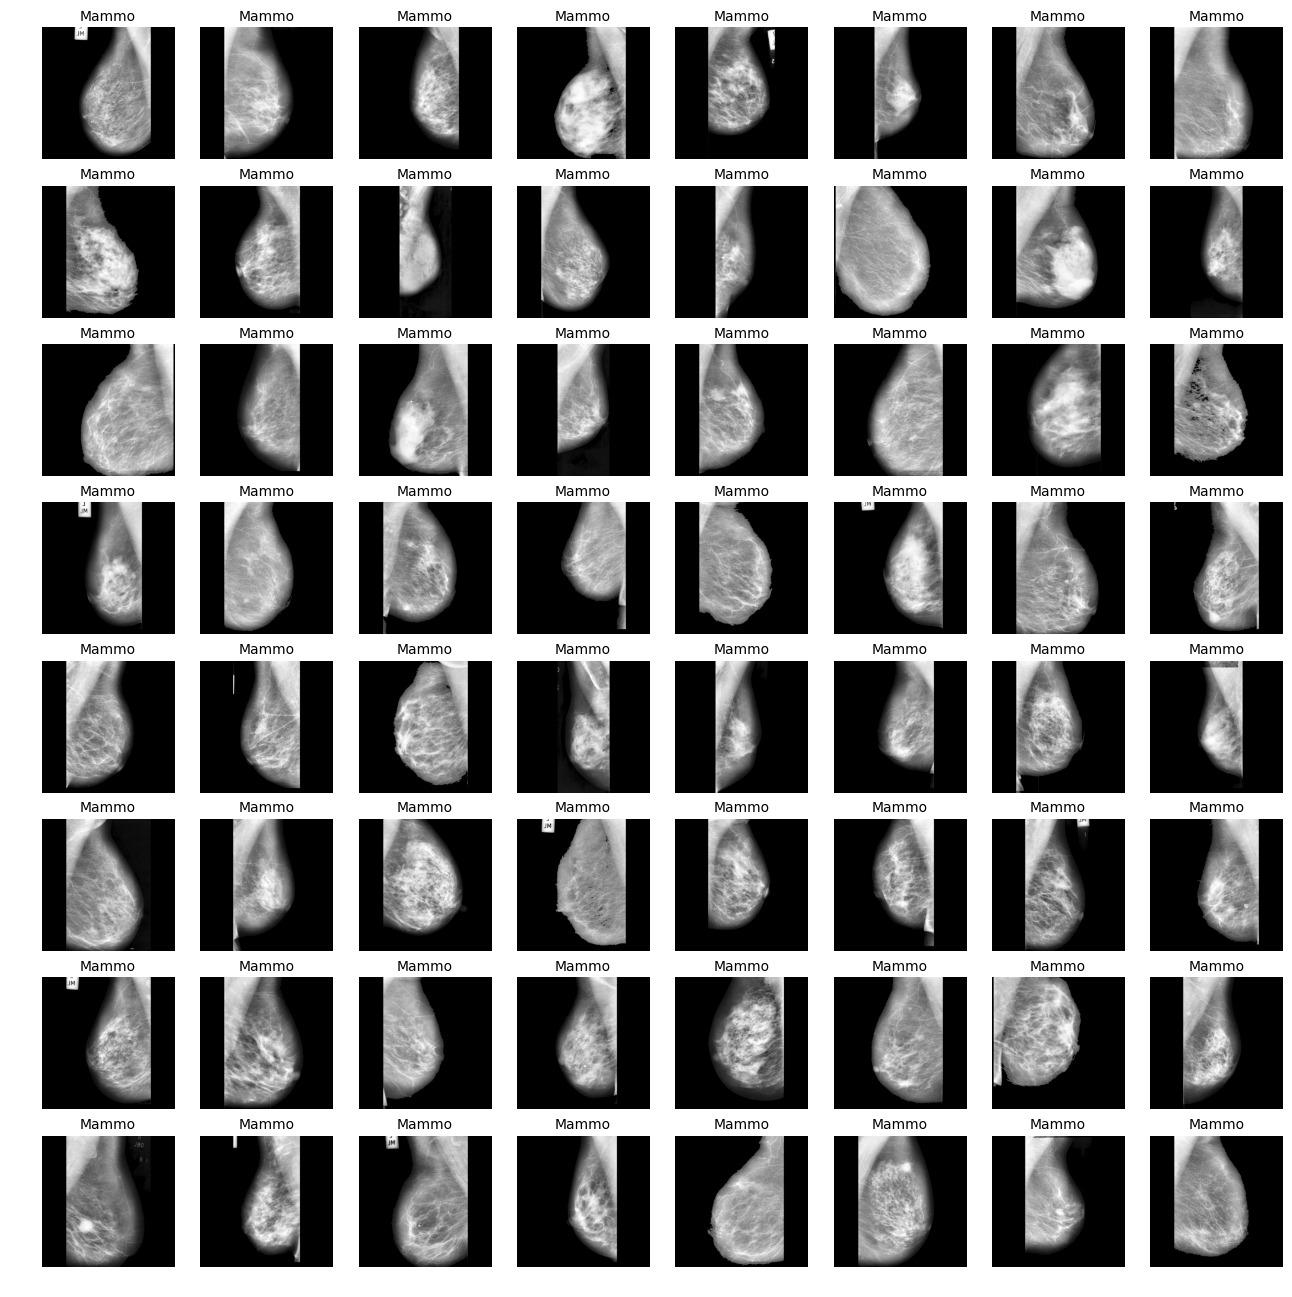

In [38]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Pick 32 Images for Display
for i in np.arange(64):
    axs[i].axis('off')
    axs[i].set_title('Mammo', fontsize=10)
    axs[i].imshow(X_data[i,:,:],cmap='gray')


# Balance the dataset via SMOTE

In [15]:
datagen = ImageDataGenerator(rotation_range=5, width_shift_range=.01, height_shift_range=0.01,
                             data_format='channels_first')

cls_cnts = MIAS.get_clsCnts(Y_data, labels)
X_data, Y_data = MIAS.balanceViaSmote(cls_cnts, meta_data, ImagesDir, AugmentedImagesDir, labels, 
                                    datagen, X_data, Y_data, imgResize=(224,224),seed=SEED, verbose=True)

normal    : 200
abnormal  : 200


# Train Test Split

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data,
                                                    test_size=0.25,
                                                    random_state=SEED,
                                                    )
print( X_train.shape)
print( X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

data = [X_train, X_test, Y_train, Y_test]

(300, 224, 224)
(100, 224, 224)
(300, 1)
(100, 1)


# Prepare VGG16 Bottle neck features

In [17]:
def VGGPrep(img_data):
    
    images = np.zeros([len(img_data), img_data.shape[1], img_data.shape[2], 3])
    for i in range(0, len(img_data)):
        im = (img_data[i] * 255)        # Original imagenet images were not rescaled
        im = color.gray2rgb(im)
        images[i] = im
    return(images)

In [18]:
def vgg16_bottleneck(data, modelPath, fn_train_feats, fn_train_lbls, fn_test_feats, fn_test_lbls):
    # Loading data
    X_train, X_test, Y_train, Y_test = data
    
    X_train = VGGPrep(X_train)
    X_test = VGGPrep(X_test)
        
    model = applications.VGG16(include_top=False, weights='imagenet') 
    
    # Predict passes data through the model 
    bottleneck_features_train = model.predict(X_train)
    
    # Saving the bottleneck features for the training data
    featuresTrain = os.path.join(modelPath, fn_train_feats)
    labelsTrain = os.path.join(modelPath, fn_train_lbls)
    
    np.save(open(featuresTrain, 'wb'), bottleneck_features_train)
    np.save(open(labelsTrain, 'wb'), Y_train)

    
    bottleneck_features_test = model.predict(X_test)
    
    # Saving the bottleneck features for the test data
    featuresTest = os.path.join(modelPath, fn_test_feats)
    labelsTest = os.path.join(modelPath, fn_test_lbls)
    np.save(open(featuresTest, 'wb'), bottleneck_features_test)
    np.save(open(labelsTest, 'wb'), Y_test)

# Save VGG16 Bottleneck features

In [21]:
# Locations for the bottleneck and labels files that we need
train_bottleneck = 'features_train.npy'
train_labels     = 'labels_train.npy'
test_bottleneck  = 'features_test.npy'
test_labels      = 'labels_test.npy'
modelPath = os.getcwd()

top_model_weights_path = './weights/'

np.random.seed(SEED)
vgg16_bottleneck(data, modelPath, train_bottleneck, train_labels, test_bottleneck, test_labels)

In [22]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        
    def on_epoch_end(self, epoch, logs={}):
        epoch_tr_loss  = logs.get('loss')
        epoch_val_loss = logs.get('val_loss')
        self.losses.append([epoch_tr_loss, epoch_val_loss])
        
        epoch_tr_acc  = logs.get('acc')
        epoch_val_acc = logs.get('val_acc')
        self.acc.append([epoch_tr_acc, epoch_val_acc])

In [23]:
def plot_losses(losses, acc):
    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.plot(losses)
    ax.set_title('Model Loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    
    ax = fig.add_subplot(222)
    ax.plot(acc)
    ax.set_title('Model Accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')

# Model with Heavy Regularization

In [24]:
def train_model(train_feats, train_lab, test_feats, test_lab, model_path, model_save, epoch = 50, batch = 64):
    start_time = time.time()
    
    train_bottleneck = os.path.join(model_path, train_feats)
    train_labels = os.path.join(model_path, train_lab)
    test_bottleneck = os.path.join(model_path, test_feats)
    test_labels = os.path.join(model_path, test_lab)
    
    history = LossHistory()
    
    X_train = np.load(train_bottleneck)
    Y_train = np.load(train_labels)
    Y_train = np_utils.to_categorical(Y_train, num_classes=2)
    
    X_test = np.load(test_bottleneck)
    Y_test = np.load(test_labels)
    Y_test = np_utils.to_categorical(Y_test, num_classes=2)

    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add( Dropout(0.7))
    model.add( Dense(256, activation='relu' ) )
    model.add( Dropout(0.5))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(2, activation='softmax'))
    
    model.compile(optimizer='rmsprop',  # adadelta
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              epochs=epoch,
              batch_size=batch,
              callbacks=[history],
              validation_data=(X_test, Y_test),
              verbose=2)
    
    print ("Training duration : {0}".format(time.time() - start_time))
    score = model.evaluate(X_test, Y_test, batch_size=16, verbose=2)

    print ("Network's test score [loss, accuracy]: {0}".format(score))
    print ('CNN Error: {:.2f}%'.format(100 - score[1] * 100))
    
    #bc.save_model(model_save, model, "jn_VGG16_Detection_top_weights_threshold.h5")
    
    return model, history.losses, history.acc, score

In [26]:
np.random.seed(SEED)
(trans_model, loss_cnn, acc_cnn, test_score_cnn) = train_model(train_feats=train_bottleneck,
                                                                   train_lab=train_labels, 
                                                                   test_feats=test_bottleneck, 
                                                                   test_lab=test_labels,
                                                                   model_path=modelPath, 
                                                                   model_save=top_model_weights_path,
                                                                   epoch=75)

Train on 300 samples, validate on 100 samples
Epoch 1/75
0s - loss: 6.5563 - acc: 0.5367 - val_loss: 7.3845 - val_acc: 0.4900
Epoch 2/75
0s - loss: 7.0093 - acc: 0.5533 - val_loss: 8.1346 - val_acc: 0.4500
Epoch 3/75
0s - loss: 7.7451 - acc: 0.5067 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 4/75
0s - loss: 7.3972 - acc: 0.5333 - val_loss: 7.7854 - val_acc: 0.5100
Epoch 5/75
0s - loss: 6.8345 - acc: 0.5600 - val_loss: 7.4742 - val_acc: 0.5200
Epoch 6/75
0s - loss: 6.9950 - acc: 0.5533 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 7/75
0s - loss: 7.2430 - acc: 0.5333 - val_loss: 6.4825 - val_acc: 0.5800
Epoch 8/75
0s - loss: 6.9508 - acc: 0.5500 - val_loss: 6.2759 - val_acc: 0.6000
Epoch 9/75
0s - loss: 6.3212 - acc: 0.5900 - val_loss: 8.0217 - val_acc: 0.5000
Epoch 10/75
0s - loss: 7.1338 - acc: 0.5400 - val_loss: 5.6830 - val_acc: 0.6200
Epoch 11/75
0s - loss: 6.3600 - acc: 0.5967 - val_loss: 4.9384 - val_acc: 0.6400
Epoch 12/75
0s - loss: 5.4157 - acc: 0.6400 - val_loss: 5.7156 - val_acc

**- Network's test score [loss, accuracy]: [4.0544894790649417, 0.72999999999999998]**


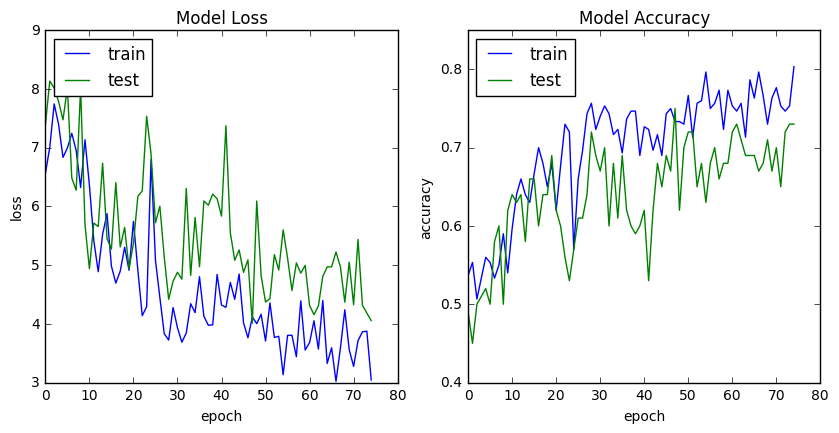

In [27]:
plt.figure(figsize=(10,10))
plot_losses(loss_cnn, acc_cnn)